## Enzyme Kinetics (Part 2)

We have already implemented a model in which an enzyme E aids a reaction in which a substrate S is consumed to produce a product P.

\begin{eqnarray*}
\frac{dS}{dt} &=& -k_1\cdot S\cdot E + k_{-1}\cdot SE\\
\frac{dE}{dt} &=& -k_1S\cdot E + k_{-1}SE + k_2\cdot SE\\
\frac{dP}{dt} &=& k_2\cdot SE\\
\frac{dSE}{dt} &=& k_1\cdot S\cdot E - k_{-1}\cdot SE - k_2\cdot SE\\
\end{eqnarray*}

where SE is the compound of S and E.

Our goal today is to rewrite the model with ODEs for S and P, but not E or ES.

First, we rerun the model from Tuesday.

In [37]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

def enzyme_model( t, y, params ):
    S = y[0]
    E = y[1]
    P = y[2]
    SE = y[3]

    k1f = params[0]
    k1b = params[1]
    k2 = params[2]

    dydt = np.zeros( (4,) )
    dydt[0] = -k1f*S*E + k1b*SE # S
    dydt[1] = -k1f*S*E + k1b*SE + k2*SE #E
    dydt[2] = k2*SE #P
    dydt[3] = k1f*S*E - k1b*SE - k2*SE #SE
    return dydt

### Simulating when Enzyme concentration is low
Typically, the enzyme concentration is low.

Use k1f = 2, k1b=2, k2 = 3, S(0) = 100, E(0) = 1, SE(0) = 0, P(0) = 0.

Simulate with from t=0 to t=100 with a timestep of 0.1

In [27]:
k1f = 2
k1b = 1
k2 = 3
params = (k1f, k1b, k2)

S0 = 100
E0 = 1
SE0 = 0
P0 = 0
yinit = (S0,E0,P0,SE0)

em = lambda t,y: enzyme_model(t,y,params)
sol = scipy.integrate.solve_ivp( fun=em, t_span=(0,100), y0=yinit, 
                                 t_eval=np.arange(0,100,1) )

Plot the simulation over time.

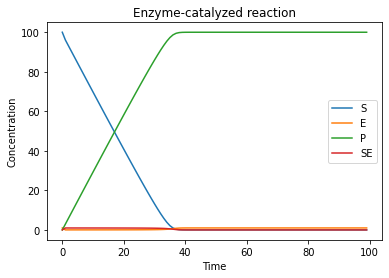

In [28]:
plt.plot( sol.t, sol.y.T )
plt.xlabel( "Time")
plt.ylabel( "Concentration" )
plt.legend( ["S","E","P","SE"])
plt.title( "Enzyme-catalyzed reaction");

If we zoom in on the ES complex, we see that it is nearly flat. 

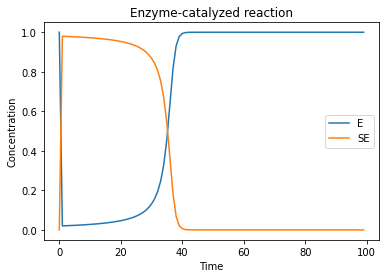

In [29]:
plt.figure()
plt.plot( sol.t, sol.y[1,:].T )
plt.plot( sol.t, sol.y[3,:].T )
plt.xlabel( "Time")
plt.ylabel( "Concentration" )
plt.legend( ["E","SE"])
plt.title( "Enzyme-catalyzed reaction");

We are interested in learning how to express dP/dt in terms of S and have learned that the Michaelis-Menton equation can do that for us. If we make the assumption that it is essentially at steady-state (called the Quasi-Steady-State Assumption), then we can work out a new expression for $\frac{dP}{dt}$

The curve dP/dt vs S can be expressed as

$v_{max}\frac{S}{K_m+S}$

where

$v_{max} = E(0)\cdot k_2$

and 

$K_m = \frac{k_{-1}+k_2}{k_1}$

Let's see if that expression fits with the full 4-ODE simulation.

Plot the analytic curve (from the Michaelis-Mention model for enzyme kinetics) on the same plot as the approximated dP/dt (to approximate dP/dt, compute the change in P divided by the timestep using np.diff).

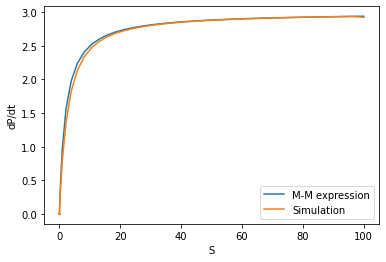

In [30]:
# Estimate the curve dP/dt from the simulation output
P = sol.y[2,:].T
S = sol.y[0,:-1].T
velocity_of_P = np.divide(np.diff(P), (sol.t[1]-sol.t[0]))

# Now compute it according to the Michaelis-Mention equation
Km = (k1b + k2)/k1f
vmax = E0*k2
analytic_dPdt = vmax * np.divide( S, (S+Km) )
plt.plot(S, analytic_dPdt)
plt.plot( S, velocity_of_P)
plt.xlabel( "S")
plt.ylabel("dP/dt")
plt.legend( ["M-M expression","Simulation"]);

### Model Enzyme Kinetics with the Michaelis-Menton Equation

Implement a model that uses the M-M equation

In [31]:
def MM_model( t, y, params ):
    vmax = params[0]
    Km = params[1]
    S = y[0]
    P = y[1]
    dydt = np.zeros( (2,) )
    dydt[0] = -vmax * S/(S+Km)
    dydt[1] = vmax * S/(S+Km)
    return dydt

Using the same initial conditions as above, and computing Km and vmax according to

$v_{max} = E(0)\cdot k_2$

and 

$K_m = \frac{k_{-1}+k_2}{k_1}$

simulate the M-M model for the same time steps as the full model.

In [32]:
vmax = E0*k2
Km = (k1b+k2)/k1f

em2 = lambda t,y: MM_model(t,y,(vmax,Km))
sol2 = scipy.integrate.solve_ivp( fun=em2, t_span=(0,100), y0=(S0,P0), 
                                 t_eval=np.arange(0,100,1) )

Plot the new model's simulation results

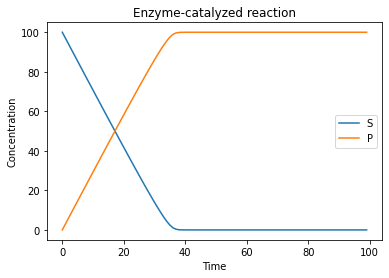

In [33]:
plt.plot( sol2.t, sol2.y.T )
plt.xlabel( "Time")
plt.ylabel( "Concentration" )
plt.legend( ["S","P"])
plt.title( "Enzyme-catalyzed reaction");

Now compare P from one model to the other by plotting them both

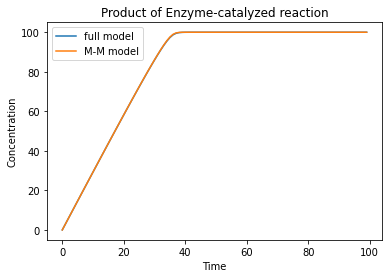

In [34]:
P_full = sol.y[2,:]
P_MM = sol2.y[1,:]
plt.plot( sol.t, P_full )
plt.plot( sol.t, P_MM )
plt.xlabel( "Time")
plt.ylabel( "Concentration" )
plt.legend( ["full model","M-M model"])
plt.title( "Product of Enzyme-catalyzed reaction");

Awesome, the full model and the M-M model are nearly indistinguishable. When we are modeling a process using M-M kinetics, we need two parameters, $v_{max}$ and $K_m$. Above, we saw that the two parameters depend on a larger set of parameters and the initial concentration of E. Typically, we will be assigning values directly to $v_{max}$ and $K_m$, skipping the step of determining separate parameters for forward and backward reaction rates. We should develop and intuition for how $v_{max}$ and $K_m$ affect dP/dt and P(t).

$v_{max}$ is simply the maximum value of dP/dt.

$K_m$ is often referred to as the activation threshold because it identifies the concentration of S that causes dP/dt to be at half it maximum. 

Make an array of S values and compute the M-M equationn for a range of values of Km. The trend is that curves with larger Km are less steep.

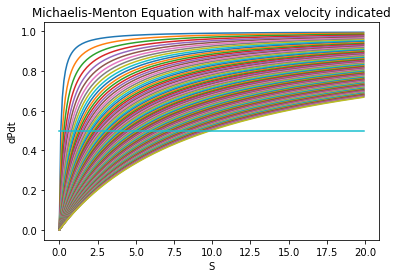

In [35]:
vmax = 1
Kms = np.arange( 0.1, 10, 0.1 )
fakeS = np.arange( 0, 20, 0.1 )
for i in range(Kms.size):
    Km = Kms[i]
    MM = vmax * np.divide( fakeS, (fakeS+Km) )
    plt.plot( fakeS, MM )
plt.plot( fakeS, vmax/2*np.ones(fakeS.shape));
plt.xlabel( 'S')
plt.ylabel( "dPdt")
plt.title( "Michaelis-Menton Equation with half-max velocity indicated");

Run the simulation with a small Km and compare it to a simulation with a large Km

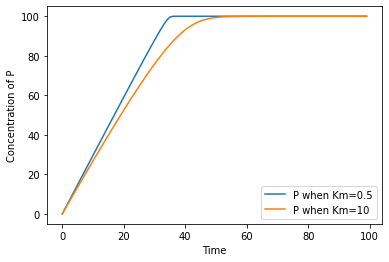

In [36]:
Km1 = 1
Km2 = 10
vmax = E0*k2

em3 = lambda t,y: MM_model(t,y,(vmax,Km1))
sol3 = scipy.integrate.solve_ivp( fun=em3, t_span=(0,100), y0=(S0,P0), 
                                 t_eval=np.arange(0,100,1) )
em4 = lambda t,y: MM_model(t,y,(vmax,Km2))
sol4 = scipy.integrate.solve_ivp( fun=em4, t_span=(0,100), y0=(S0,P0), 
                                 t_eval=np.arange(0,100,1) )

plt.plot( sol3.t, sol3.y[1,:])
plt.plot( sol3.t, sol4.y[1,:])
plt.xlabel( "Time")
plt.ylabel( "Concentration of P")
plt.legend( ['P when Km=0.5', 'P when Km=10']);

# Compare to S -> P

This is bonus material that shows that enzyme-aided production is fundamentally different from simple production. The rate of production can become saturated (reach an upper limit) with enyme-aided production, but not with simple production. We see this by plotting the rate of production of P in the simple production model. The rate is linear. This is in contrast to the similar plot from enyme-aided production, in which the rate reaches a threshold and flattens out.

In [ ]:
def production_model( t, y, params ):
    S = y[0]
    P = y[1]

    k1 = params[0]

    dydt = np.zeros( (2,) )
    dydt[0] = -k1*S # S
    dydt[1] = k1*S #P
    return dydt

k1 = 0.1
params = (k1,)

S0 = 100
P0 = 0
yinit = (S0,P0)

em = lambda t,y: production_model(t,y,params)
sol = scipy.integrate.solve_ivp( fun=em, t_span=(0,100), y0=yinit, 
                                 t_eval=np.arange(0,100,1) )

plt.plot( sol.t, sol.y.T )
plt.xlabel( "Time")
plt.ylabel( "Concentration" )
plt.legend( ["S","P"])
plt.title( "Production reaction");

# Estimate the curve dP/dt from the simulation output
P = sol.y[1,:].T
S = sol.y[0,:-1].T
velocity_of_P = np.divide(np.diff(P), (sol.t[1]-sol.t[0]))
RHS = k1*S

# Now compute it according to the Michaelis-Mention equation
plt.figure()
plt.plot(S, velocity_of_P)
plt.plot(S, RHS)
plt.xlabel( "S")
plt.ylabel("dP/dt")
plt.legend( ["Simulation","RHS"]);
plt.title( "Rate of Production Reaction")